In [1]:
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
import os
import sys
import random
import numpy as np
import glob
import pandas as pd
from tqdm import tqdm
import tifffile as tif
from PIL import Image
from skimage.io import imread,imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.models import Model
import zipfile
import tifffile as tiff
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model

In [2]:
zip_dir = '/content/drive/MyDrive/DataSet/satalite_data.zip'
zip_ref = zipfile.ZipFile(zip_dir, 'r')
zip_ref.extractall('/content/sample_data')
zip_ref.close()

In [3]:
main_dir = '/content/sample_data/satalite data/data'
images_dir = os.path.join(main_dir, 'images')
labels_dir = os.path.join(main_dir, 'labels')

In [4]:
for dir, dirname, filename in os.walk(images_dir):
  print(f"Found {len(dirname)} directories and {len(filename)} images in {dir}")

print('-'*100)

for dir, dirname, filename in os.walk(labels_dir):
  print(f"Found {len(dirname)} directories and {len(filename)} images in {dir}")

Found 0 directories and 306 images in /content/sample_data/satalite data/data/images
----------------------------------------------------------------------------------------------------
Found 0 directories and 456 images in /content/sample_data/satalite data/data/labels


In [5]:
allowed_indices = set(str(i) + ".png" for i in range(0, 306))
for filename in os.listdir(labels_dir):
    if filename.endswith('.png'):
        if filename not in allowed_indices:
            os.remove(os.path.join(labels_dir, filename))
            print(f"Deleted: {filename}")
    else:
        # Optionally remove non-jpg images too
        os.remove(os.path.join(labels_dir, filename))
        print(f"Deleted (non-jpg): {filename}")

Deleted: 12_286.png
Deleted: 93_217.png
Deleted: 111_121.png
Deleted: 42_281.png
Deleted: 72_205.png
Deleted: 147_213.png
Deleted: 97_130.png
Deleted: 71_120.png
Deleted: 96_154.png
Deleted: 85_117.png
Deleted: 105_148.png
Deleted: 57_45.png
Deleted: 16_229.png
Deleted: 119_222.png
Deleted: 116_250.png
Deleted: 150_243.png
Deleted: 3_74.png
Deleted: 78_246.png
Deleted: 4_300.png
Deleted: 144_235.png
Deleted: 43_149.png
Deleted: 99_170.png
Deleted: 149_166.png
Deleted: 38_68.png
Deleted: 125_201.png
Deleted: 133_224.png
Deleted: 138_39.png
Deleted: 28_2.png
Deleted: 22_16.png
Deleted: 53_43.png
Deleted: 101_89.png
Deleted: 86_288.png
Deleted: 115_49.png
Deleted: 122_257.png
Deleted: 49_64.png
Deleted: 142_238.png
Deleted: 130_256.png
Deleted: 2_215.png
Deleted: 80_124.png
Deleted: 19_293.png
Deleted: 11_116.png
Deleted: 103_225.png
Deleted: 68_180.png
Deleted: 24_111.png
Deleted: 64_86.png
Deleted: 7_146.png
Deleted: 14_135.png
Deleted: 23_251.png
Deleted: 98_253.png
Deleted: 106_267.pn

In [6]:
# Sort filenames numerically (e.g., img_1.tif < img_10.tif)
def sort_key(file):
    return int(''.join(filter(str.isdigit, file)))  # extract numbers from filename
# Get sorted file paths
images = sorted(
    [os.path.join(images_dir, file) for file in os.listdir(images_dir) if file.endswith('.tif')],
    key=sort_key)

masks = sorted(
    [os.path.join(labels_dir, file) for file in os.listdir(labels_dir) if file.endswith(('.png', '.tif'))],
    key=sort_key)

# Combine into DataFrame
data = pd.DataFrame({"image": images, "mask": masks})

# Train/Validation split
train_df, val_df = train_test_split(data, train_size=0.8, random_state=123)


In [7]:
def plot_channels_with_mask(image_path, mask_path, max_channels=12):
    # Load .tif image
    image = tiff.imread(image_path)

    # If shape is (C, H, W), transpose to (H, W, C)
    if image.ndim == 3 and image.shape[0] <= 15:
        image = np.transpose(image, (1, 2, 0))

    # Drop channels 1, 9, and 10 (indices 0, 8, 9)
    drop_indices = [0, 8, 9]
    image = np.delete(image, drop_indices, axis=2)

    # Corresponding channel names (remove dropped ones)
    all_channel_names = [
        "Coastal", "Blue", "Green", "Red",
        "Red Edge 1", "Red Edge 2", "Red Edge 3",
        "NIR", "Narrow NIR", "SWIR 1", "SWIR 2", "Water Vapor"
    ]
    kept_channel_names = [name for i, name in enumerate(all_channel_names) if i not in drop_indices]

    # Load mask (assumed to be grayscale .png)
    mask = np.array(Image.open(mask_path))

    # Plot
    channels = image.shape[2]
    total_plots = min(channels, max_channels) + 1
    cols = 4
    rows = int(np.ceil(total_plots / cols))

    plt.figure(figsize=(15, rows * 3))

    # Plot channels with real names
    for i in range(min(channels, max_channels)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image[:, :, i], cmap='gray')
        plt.title(kept_channel_names[i])  # Use real name
        plt.axis('off')

    # Plot mask
    plt.subplot(rows, cols, total_plots)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

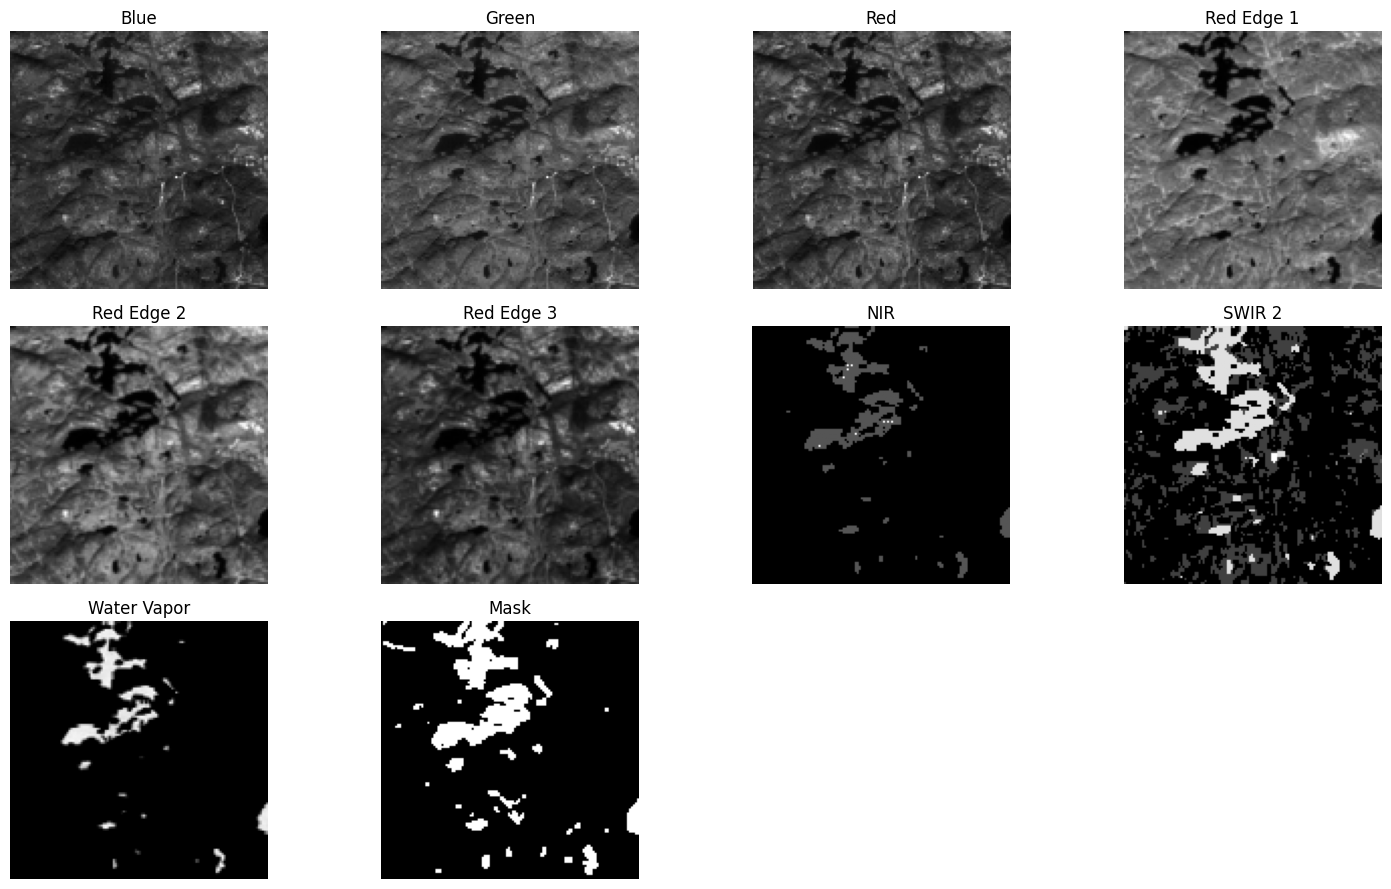

In [8]:
plot_channels_with_mask(images[0],masks[0])

In [8]:
def normalize(band):
    return (band - band.min()) / (band.max() - band.min() + 1e-6)

def compare_rgb_and_mask(image_path, mask_path, rgb_indices=(0, 1, 2), drop_indices=[0, 8, 9]):
    # Load .tif image
    image = tiff.imread(image_path)

    # Transpose to (H, W, C) if needed
    if image.ndim == 3 and image.shape[0] <= 15:
        image = np.transpose(image, (1, 2, 0))

    # Drop specified channels
    image = np.delete(image, drop_indices, axis=2)

    # Extract and normalize RGB channels (R, G, B)
    rgb = np.stack([
        normalize(image[:, :, rgb_indices[2]]),  # R
        normalize(image[:, :, rgb_indices[1]]),  # G
        normalize(image[:, :, rgb_indices[0]])   # B
    ], axis=2)

    # Load mask
    mask = np.array(Image.open(mask_path))
    if mask.ndim == 3:
        mask = mask[:, :, 0]

    # Plot side-by-side comparison
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(rgb)
    plt.title('RGB Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(rgb)
    plt.imshow(mask, cmap='gray', alpha=0.4)
    plt.title('RGB + Mask Overlay')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

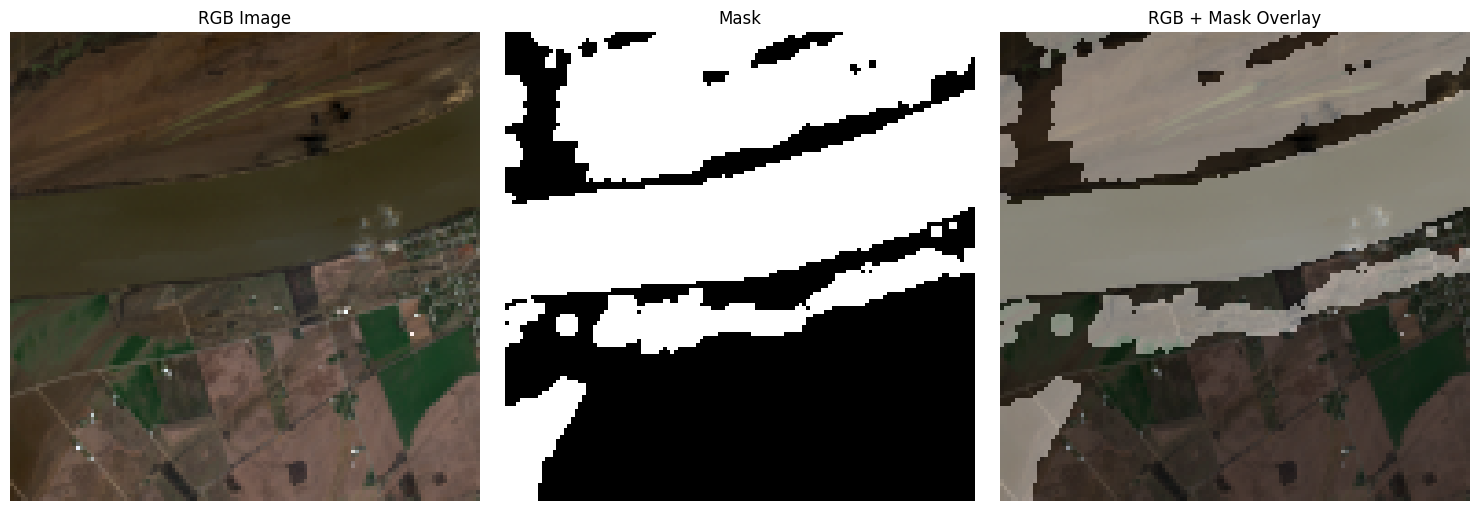

In [10]:
compare_rgb_and_mask(train_df.iloc[0]['image'], train_df.iloc[0]['mask'])

In [9]:
def normalize(band):
    return (band - band.min()) / (band.max() - band.min() + 1e-6)

def compare_ndwi_with_mask(image_path, mask_path, green_index=1, nir_index=6, drop_indices=[0, 8, 9]):
    # Load image and drop unwanted channels
    image = tiff.imread(image_path)
    if image.ndim == 3 and image.shape[0] < 20:
        image = np.transpose(image, (1, 2, 0))
    image = np.delete(image, drop_indices, axis=2)

    # Extract Green and NIR bands
    green = normalize(image[:, :, green_index])
    nir   = normalize(image[:, :, nir_index])

    # Compute NDWI
    ndwi = (green - nir) / (green + nir + 1e-6)

    # Load and process mask
    mask = np.array(Image.open(mask_path))
    if mask.ndim == 3:
        mask = mask[:, :, 0]

    # Plot NDWI and mask
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(ndwi, cmap='Blues')
    plt.title('NDWI')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

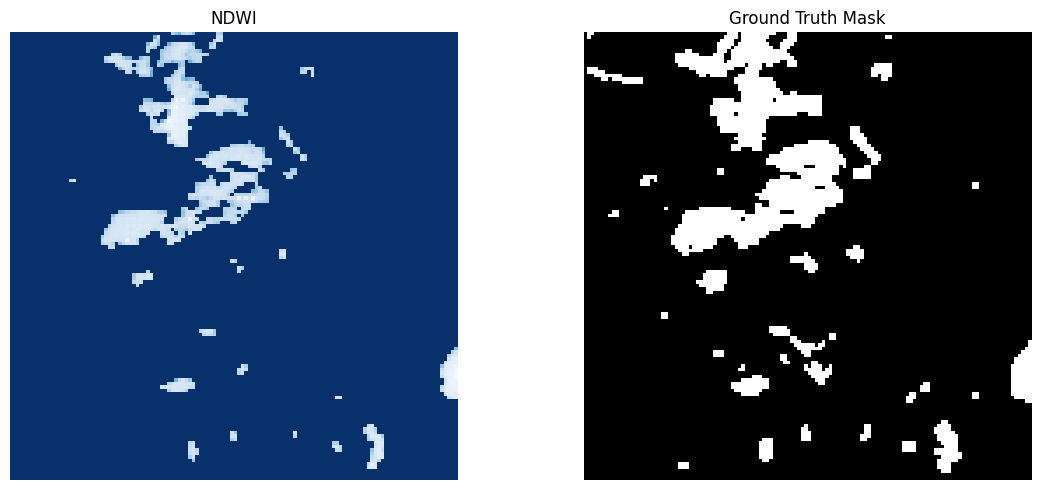

In [10]:
compare_ndwi_with_mask(
    image_path=images[0],
    mask_path=masks[0],
    green_index=1,  # Adjust based on your data
    nir_index=6     # Adjust based on band order *after dropping*
)

In [11]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, image_dir, mask_dir, batch_size=12, target_size=(128, 128), shuffle=True):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.drop_indices = [0, 8, 9]  # Channels to drop
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.dataframe) / self.batch_size))

    def normalize_image(self, image):
        # Normalize each channel independently
        for c in range(image.shape[2]):
            band = image[:, :, c]
            min_val, max_val = band.min(), band.max()
            image[:, :, c] = (band - min_val) / (max_val - min_val + 1e-6)
        return image

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        list_ids_x = [self.dataframe.iloc[k]["image"] for k in indexes]
        list_ids_y = [self.dataframe.iloc[k]["mask"] for k in indexes]

        # After dropping 3 channels, we have 12 - 3 = 9
        X = np.empty((self.batch_size, *self.target_size, 9), dtype=np.float32)
        y = np.empty((self.batch_size, *self.target_size, 1), dtype=np.float32)

        for i, (img_path, mask_path) in enumerate(zip(list_ids_x, list_ids_y)):
            img = tif.imread(img_path).astype(np.float32)

            # Transpose from (C, H, W) → (H, W, C)
            if img.ndim == 3 and img.shape[0] <= 15:
                img = np.transpose(img, (1, 2, 0))

            # Drop specific channels
            img = np.delete(img, self.drop_indices, axis=2)

            # Resize image
            img = resize(img, self.target_size, anti_aliasing=True, preserve_range=True)

            # Normalize per channel
            img = self.normalize_image(img)

            # Load and resize mask
            mask = imread(mask_path, as_gray=True).astype(np.float32)
            mask = resize(mask, self.target_size, anti_aliasing=True, preserve_range=True)

            X[i] = img
            y[i] = np.expand_dims(mask, axis=-1)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.dataframe))
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [12]:
train_generator = CustomDataGenerator(train_df, images_dir, labels_dir, batch_size=12, target_size=(128, 128), shuffle=True)
val_generator = CustomDataGenerator(val_df, images_dir, labels_dir, batch_size=12, target_size=(128, 128), shuffle=False)

In [15]:
def unet_model(input_size=(128, 128, 9)):
    inputs = Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)


    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

model = unet_model(input_size=(128, 128, 9))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 9)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      5,248 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,035,201 (118.39 MB)

 Trainable params: 31,035,201 (118.39 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5,min_lr=1e-6 ,verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

In [17]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    steps_per_epoch=len(train_df) // 12,
    validation_steps=len(val_df) // 12,
    callbacks=callbacks)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 9))
  warnings.warn(msg)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.7590 - loss: 0.5515

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 9))
  warnings.warn(msg)


20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 765ms/step - accuracy: 0.7616 - loss: 0.5468 - val_accuracy: 0.6525 - val_loss: 0.8510 - learning_rate: 0.0010
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.8189 - loss: 0.4602 - val_accuracy: 0.9114 - val_loss: 0.2820 - learning_rate: 0.0010
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 0.8782 - loss: 0.3266 - val_accuracy: 0.9109 - val_loss: 0.2755 - learning_rate: 0.0010
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.8958 - loss: 0.2932 - val_accuracy: 0.9132 - val_loss: 0.2870 - learning_rate: 0.0010
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - accuracy: 0.8911 - loss: 0.3063 - val_accuracy: 0.9139 - val_loss: 0.2693 - learning_rate: 0.0010
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - accuracy: 0.9054 - loss: 0.2699 - val_accuracy: 0.9151 - val_loss: 0.2722 - learning_rate: 0.0010
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - accuracy: 0.8980 - loss: 0.2897 - val_accura

In [19]:
loss, accuracy= model.evaluate(val_generator, steps=5)

print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9327 - loss: 0.2039
Validation Loss: 0.2234
Validation Accuracy: 0.9233


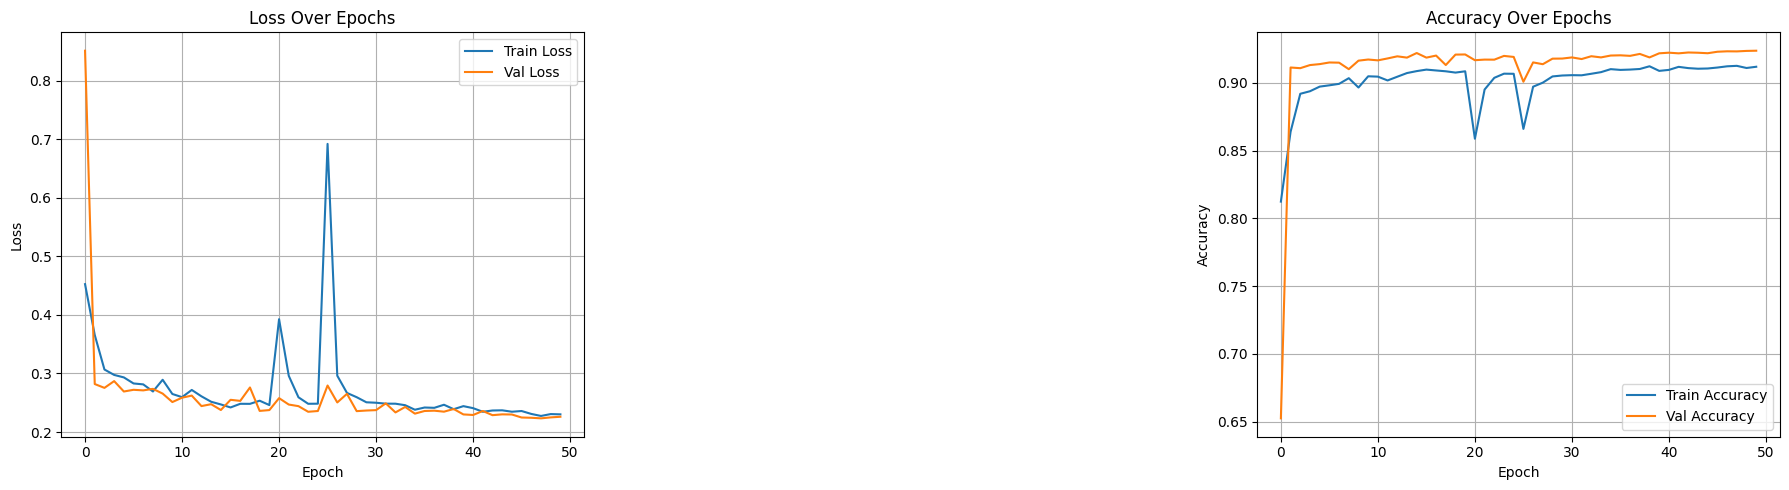

In [21]:
plt.figure(figsize=(18, 5))  # Wider figure for 3 plots

# ----- Loss -----
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


# ----- Accuracy -----
plt.subplot(1, 3, 3)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(12, 128, 128, 9))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step


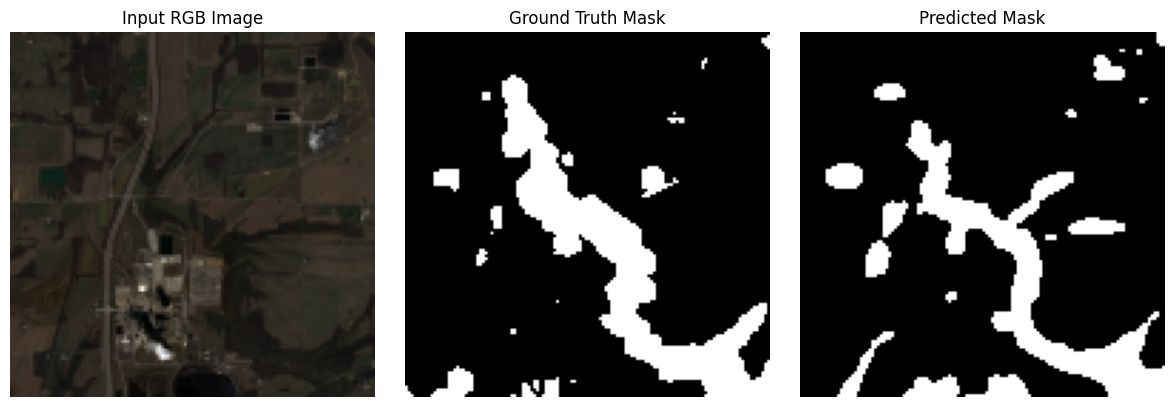

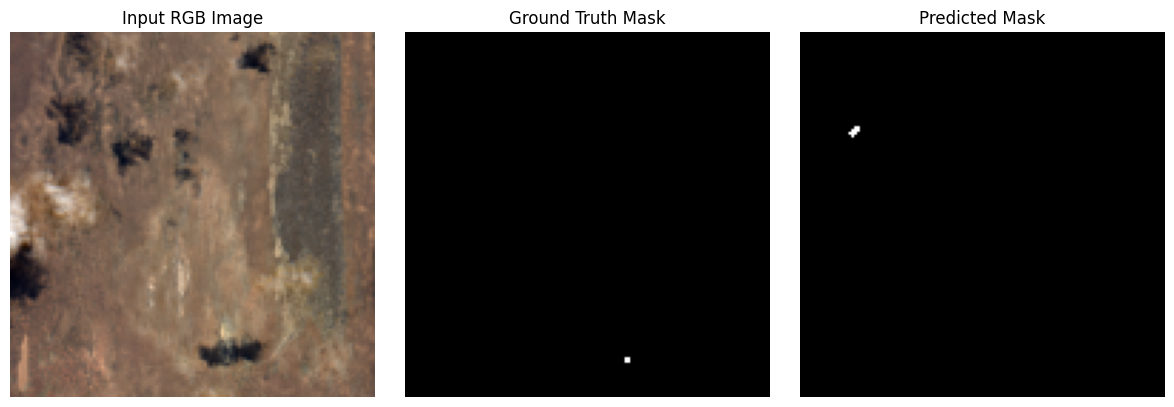

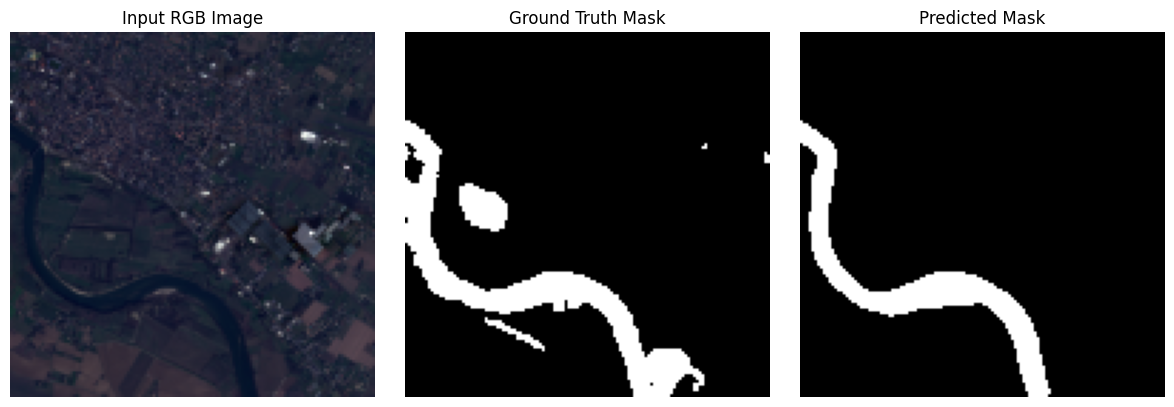

In [22]:
import matplotlib.pyplot as plt

# Get a batch from the validation generator
images, true_masks = next(iter(val_generator))

# Predict masks
pred_masks = model.predict(images)
pred_masks = (pred_masks > 0.5).astype(np.uint8)  # Binarize prediction

# Show a few comparisons
num_samples = 3  # Number of samples to show
for i in range(num_samples):
    plt.figure(figsize=(12, 4))

    # RGB image (use channels 1, 2, 3 if available)
    rgb = images[i][:, :, [2, 1, 0]]  # assuming channels are in order after drop

    plt.subplot(1, 3, 1)
    plt.imshow(rgb)
    plt.title("Input RGB Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(true_masks[i].squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_masks[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [16]:
pip install git+https://github.com/qubvel/segmentation_models


  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-jw0t3bzq
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-jw0t3bzq
  Resolved https://github.com/qubvel/segmentation_models to commit 5d24bbfb28af6134e25e2c0b79e7727f6c0491d0
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.7 MB/s eta 0:00:00
  Created wheel for segmentation_models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33789 sha256=6e1b6d92219a4ddfe58e1ff319ff1fcb84a5d475c3bac881b5da15b5b1effabf
  Stored in directory: /tmp/pip-ephem-wheel-cache-gowpb9l5/wheels/54/34/7f/b2b4efb59db0271239ccc6450d45591df6c415c7748d1b7650
Successfully built segmentation_models


In [18]:
import segmentation_models as sm

# Define loss and metrics
loss = sm.losses.DiceLoss() + sm.losses.BinaryFocalLoss()
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]



callbacks = [
    EarlyStopping(patience=15, monitor='val_iou_score', mode='max'),
    ReduceLROnPlateau(factor=0.1, patience=5),
    ModelCheckpoint(f'best_model_option{option}.h5',
                   save_best_only=True,
                   monitor='val_iou_score',
                   mode='max')]

Using Option 1: Direct modification


/usr/local/lib/python3.11/dist-packages/keras_applications/imagenet_utils.py:276: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 9 input channels.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 9)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │      3,240 │ input_layer[0][0] │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        960 │ block1a_se_excit… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 64, 64,    │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_dwconv      │ (None, 64, 64,    │        216 │ block1a_project_… │
│ (DepthwiseConv2D)   │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_bn          │ (None, 64, 64,    │         96 │ block1b_dwconv[0… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_activation  │ (None, 64, 64,    │          0 │ block1b_bn[0][0]

 Total params: 17,869,993 (68.17 MB)

 Trainable params: 17,780,713 (67.83 MB)

 Non-trainable params: 89,280 (348.75 KB)

In [39]:
BACKBONE = 'efficientnetb3'
LR = 1e-4
BATCH_SIZE = 16
INPUT_SHAPE = (128, 128, 9)

model2=sm.Unet(
        BACKBONE,
        input_shape=INPUT_SHAPE,
        classes=1,
        activation='sigmoid',
        encoder_weights=None,  # Must be None
        encoder_freeze=False,
        decoder_use_batchnorm=True)

model2.compile(optimizer=Adam(LR),loss=loss,metrics=metrics)

model2.summary()

/usr/local/lib/python3.11/dist-packages/keras_applications/imagenet_utils.py:276: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 9 input channels.
  warnings.warn(


In [40]:
history = model2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks,
    batch_size=BATCH_SIZE
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - f1-score: 0.4514 - iou_score: 0.2965 - loss: 0.7502

20/20 ━━━━━━━━━━━━━━━━━━━━ 149s 822ms/step - f1-score: 0.4530 - iou_score: 0.2980 - loss: 0.7488 - val_f1-score: 0.0116 - val_iou_score: 0.0058 - val_loss: 0.8042 - learning_rate: 1.0000e-04
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - f1-score: 0.5673 - iou_score: 0.4121 - loss: 0.6420 - val_f1-score: 0.0114 - val_iou_score: 0.0057 - val_loss: 0.7949 - learning_rate: 1.0000e-04
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - f1-score: 0.6553 - iou_score: 0.4959 - loss: 0.5602 - val_f1-score: 0.0083 - val_iou_score: 0.0042 - val_loss: 0.7801 - learning_rate: 1.0000e-04
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - f1-score: 0.7172 - iou_score: 0.5660 - loss: 0.5047 - val_f1-score: 5.3276e-04 - val_iou_score: 2.6647e-04 - val_loss: 0.7732 - learning_rate: 1.0000e-04
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - f1-score: 0.7003 - iou_score: 0.5462 - loss: 0.5050 - val_f1-score: 2.4543e-04 - val_iou_score: 1.2274e-04 - val_loss: 0.7703 - learning_rate: 1.00

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - f1-score: 0.7535 - iou_score: 0.6115 - loss: 0.4298 - val_f1-score: 0.0140 - val_iou_score: 0.0070 - val_loss: 0.7307 - learning_rate: 1.0000e-04
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - f1-score: 0.7751 - iou_score: 0.6429 - loss: 0.3911 - val_f1-score: 0.0070 - val_iou_score: 0.0035 - val_loss: 0.7827 - learning_rate: 1.0000e-04
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - f1-score: 0.7775 - iou_score: 0.6413 - loss: 0.3874

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 247ms/step - f1-score: 0.7775 - iou_score: 0.6416 - loss: 0.3874 - val_f1-score: 0.1687 - val_iou_score: 0.0923 - val_loss: 0.7324 - learning_rate: 1.0000e-04
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - f1-score: 0.7793 - iou_score: 0.6434 - loss: 0.3752

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - f1-score: 0.7797 - iou_score: 0.6440 - loss: 0.3753 - val_f1-score: 0.4789 - val_iou_score: 0.3330 - val_loss: 0.6734 - learning_rate: 1.0000e-04
Epoch 13/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - f1-score: 0.7947 - iou_score: 0.6677 - loss: 0.3667 - val_f1-score: 0.3855 - val_iou_score: 0.2545 - val_loss: 0.7021 - learning_rate: 1.0000e-04
Epoch 14/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - f1-score: 0.7828 - iou_score: 0.6479 - loss: 0.3675 - val_f1-score: 0.4197 - val_iou_score: 0.2743 - val_loss: 0.7059 - learning_rate: 1.0000e-04
Epoch 15/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - f1-score: 0.7839 - iou_score: 0.6518 - loss: 0.3933

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - f1-score: 0.7843 - iou_score: 0.6524 - loss: 0.3921 - val_f1-score: 0.5193 - val_iou_score: 0.3693 - val_loss: 0.6259 - learning_rate: 1.0000e-04
Epoch 16/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - f1-score: 0.8146 - iou_score: 0.6900 - loss: 0.3349

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - f1-score: 0.8142 - iou_score: 0.6895 - loss: 0.3353 - val_f1-score: 0.7255 - val_iou_score: 0.5756 - val_loss: 0.4770 - learning_rate: 1.0000e-04
Epoch 17/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - f1-score: 0.7839 - iou_score: 0.6571 - loss: 0.3660

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - f1-score: 0.7837 - iou_score: 0.6570 - loss: 0.3661 - val_f1-score: 0.7256 - val_iou_score: 0.5772 - val_loss: 0.4639 - learning_rate: 1.0000e-04
Epoch 18/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - f1-score: 0.8151 - iou_score: 0.6923 - loss: 0.3258 - val_f1-score: 0.5811 - val_iou_score: 0.4259 - val_loss: 0.5466 - learning_rate: 1.0000e-04
Epoch 19/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - f1-score: 0.8145 - iou_score: 0.6904 - loss: 0.3236 - val_f1-score: 0.7088 - val_iou_score: 0.5578 - val_loss: 0.4619 - learning_rate: 1.0000e-04
Epoch 20/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - f1-score: 0.8248 - iou_score: 0.7059 - loss: 0.3003

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - f1-score: 0.8239 - iou_score: 0.7049 - loss: 0.3016 - val_f1-score: 0.7394 - val_iou_score: 0.5946 - val_loss: 0.4274 - learning_rate: 1.0000e-04
Epoch 21/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - f1-score: 0.8152 - iou_score: 0.6923 - loss: 0.3181 - val_f1-score: 0.7374 - val_iou_score: 0.5921 - val_loss: 0.4163 - learning_rate: 1.0000e-04
Epoch 22/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - f1-score: 0.8239 - iou_score: 0.7061 - loss: 0.3105

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 223ms/step - f1-score: 0.8243 - iou_score: 0.7065 - loss: 0.3098 - val_f1-score: 0.7433 - val_iou_score: 0.5996 - val_loss: 0.4014 - learning_rate: 1.0000e-04
Epoch 23/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - f1-score: 0.8526 - iou_score: 0.7469 - loss: 0.2631

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - f1-score: 0.8514 - iou_score: 0.7452 - loss: 0.2648 - val_f1-score: 0.7507 - val_iou_score: 0.6091 - val_loss: 0.3849 - learning_rate: 1.0000e-04
Epoch 24/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - f1-score: 0.8316 - iou_score: 0.7141 - loss: 0.2895

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - f1-score: 0.8312 - iou_score: 0.7136 - loss: 0.2898 - val_f1-score: 0.7569 - val_iou_score: 0.6162 - val_loss: 0.3754 - learning_rate: 1.0000e-04
Epoch 25/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - f1-score: 0.8440 - iou_score: 0.7324 - loss: 0.2707

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 338ms/step - f1-score: 0.8433 - iou_score: 0.7316 - loss: 0.2715 - val_f1-score: 0.7621 - val_iou_score: 0.6226 - val_loss: 0.3641 - learning_rate: 1.0000e-04
Epoch 26/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - f1-score: 0.8489 - iou_score: 0.7394 - loss: 0.2633

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - f1-score: 0.8489 - iou_score: 0.7396 - loss: 0.2635 - val_f1-score: 0.7719 - val_iou_score: 0.6359 - val_loss: 0.3513 - learning_rate: 1.0000e-04
Epoch 27/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - f1-score: 0.8434 - iou_score: 0.7338 - loss: 0.2683

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 325ms/step - f1-score: 0.8434 - iou_score: 0.7337 - loss: 0.2684 - val_f1-score: 0.7804 - val_iou_score: 0.6469 - val_loss: 0.3448 - learning_rate: 1.0000e-04
Epoch 28/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - f1-score: 0.8363 - iou_score: 0.7289 - loss: 0.2757

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 202ms/step - f1-score: 0.8367 - iou_score: 0.7292 - loss: 0.2752 - val_f1-score: 0.7864 - val_iou_score: 0.6561 - val_loss: 0.3373 - learning_rate: 1.0000e-04
Epoch 29/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - f1-score: 0.8547 - iou_score: 0.7500 - loss: 0.2542

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 218ms/step - f1-score: 0.8545 - iou_score: 0.7497 - loss: 0.2544 - val_f1-score: 0.7910 - val_iou_score: 0.6612 - val_loss: 0.3260 - learning_rate: 1.0000e-04
Epoch 30/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - f1-score: 0.8533 - iou_score: 0.7467 - loss: 0.2569

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - f1-score: 0.8534 - iou_score: 0.7469 - loss: 0.2567 - val_f1-score: 0.7916 - val_iou_score: 0.6630 - val_loss: 0.3199 - learning_rate: 1.0000e-04
Epoch 31/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - f1-score: 0.8439 - iou_score: 0.7338 - loss: 0.2736

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 274ms/step - f1-score: 0.8447 - iou_score: 0.7349 - loss: 0.2726 - val_f1-score: 0.8061 - val_iou_score: 0.6820 - val_loss: 0.3089 - learning_rate: 1.0000e-04
Epoch 32/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - f1-score: 0.8655 - iou_score: 0.7659 - loss: 0.2270

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 251ms/step - f1-score: 0.8653 - iou_score: 0.7656 - loss: 0.2276 - val_f1-score: 0.8119 - val_iou_score: 0.6889 - val_loss: 0.3178 - learning_rate: 1.0000e-04
Epoch 33/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - f1-score: 0.8728 - iou_score: 0.7760 - loss: 0.2277 - val_f1-score: 0.8037 - val_iou_score: 0.6763 - val_loss: 0.3224 - learning_rate: 1.0000e-04
Epoch 34/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - f1-score: 0.8682 - iou_score: 0.7684 - loss: 0.2243 - val_f1-score: 0.8104 - val_iou_score: 0.6866 - val_loss: 0.3105 - learning_rate: 1.0000e-04
Epoch 35/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - f1-score: 0.8777 - iou_score: 0.7848 - loss: 0.2169

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - f1-score: 0.8771 - iou_score: 0.7838 - loss: 0.2178 - val_f1-score: 0.8161 - val_iou_score: 0.6955 - val_loss: 0.2923 - learning_rate: 1.0000e-04
Epoch 36/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - f1-score: 0.8593 - iou_score: 0.7562 - loss: 0.2372 - val_f1-score: 0.8158 - val_iou_score: 0.6942 - val_loss: 0.2974 - learning_rate: 1.0000e-04
Epoch 37/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - f1-score: 0.8327 - iou_score: 0.7241 - loss: 0.2759 - val_f1-score: 0.8107 - val_iou_score: 0.6869 - val_loss: 0.3020 - learning_rate: 1.0000e-04
Epoch 38/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - f1-score: 0.8515 - iou_score: 0.7479 - loss: 0.2442 - val_f1-score: 0.8140 - val_iou_score: 0.6928 - val_loss: 0.2842 - learning_rate: 1.0000e-04
Epoch 39/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - f1-score: 0.8641 - iou_score: 0.7623 - loss: 0.2318

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - f1-score: 0.8644 - iou_score: 0.7629 - loss: 0.2312 - val_f1-score: 0.8244 - val_iou_score: 0.7056 - val_loss: 0.2880 - learning_rate: 1.0000e-04
Epoch 40/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - f1-score: 0.8810 - iou_score: 0.7901 - loss: 0.2077 - val_f1-score: 0.8217 - val_iou_score: 0.7026 - val_loss: 0.2825 - learning_rate: 1.0000e-04
Epoch 41/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - f1-score: 0.8927 - iou_score: 0.8074 - loss: 0.1853

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - f1-score: 0.8924 - iou_score: 0.8070 - loss: 0.1859 - val_f1-score: 0.8251 - val_iou_score: 0.7076 - val_loss: 0.2748 - learning_rate: 1.0000e-04
Epoch 42/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - f1-score: 0.8739 - iou_score: 0.7773 - loss: 0.2141 - val_f1-score: 0.8204 - val_iou_score: 0.6992 - val_loss: 0.2915 - learning_rate: 1.0000e-04
Epoch 43/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - f1-score: 0.8902 - iou_score: 0.8037 - loss: 0.1887 - val_f1-score: 0.8210 - val_iou_score: 0.7005 - val_loss: 0.2824 - learning_rate: 1.0000e-04
Epoch 44/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - f1-score: 0.8835 - iou_score: 0.7925 - loss: 0.2032 - val_f1-score: 0.8245 - val_iou_score: 0.7059 - val_loss: 0.2722 - learning_rate: 1.0000e-04
Epoch 45/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - f1-score: 0.8824 - iou_score: 0.7912 - loss: 0.2015 - val_f1-score: 0.8108 - val_iou_score: 0.6856 - val_loss: 0.2936 - learning_rate: 1.0000e-04
Epoch 4

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - f1-score: 0.9017 - iou_score: 0.8231 - loss: 0.1689 - val_f1-score: 0.8288 - val_iou_score: 0.7129 - val_loss: 0.2641 - learning_rate: 1.0000e-04
Epoch 50/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - f1-score: 0.9048 - iou_score: 0.8275 - loss: 0.1659 - val_f1-score: 0.8255 - val_iou_score: 0.7075 - val_loss: 0.2674 - learning_rate: 1.0000e-04


In [47]:
loss,FScore,IOUScore= model2.evaluate(val_generator, steps=5)

print(f'Validation Loss: {loss:.4f}')
print(f'Validation F1-Score: {FScore:.4f}')
print(f'Validation IoU: {IOUScore:.4f}')


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - f1-score: 0.8458 - iou_score: 0.7382 - loss: 0.2407
Validation Loss: 0.2674
Validation F1-Score: 0.7075
Validation IoU: 0.8255


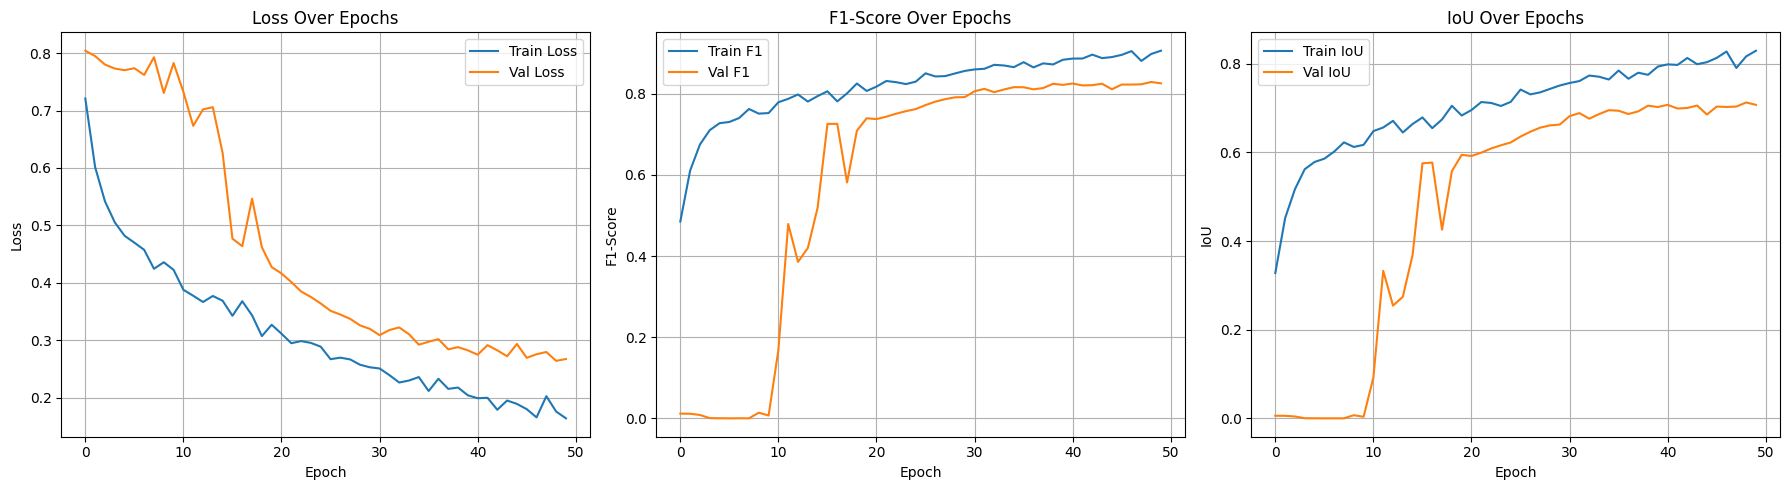

In [48]:
plt.figure(figsize=(18, 5))  # Wider figure for 3 plots

# ----- Loss -----
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# ----- FScore -----
plt.subplot(1, 3, 2)
plt.plot(history.history['f1-score'], label='Train F1')
plt.plot(history.history['val_f1-score'], label='Val F1')
plt.title('F1-Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True)

# ----- IoU -----
plt.subplot(1, 3, 3)
plt.plot(history.history['iou_score'], label='Train IoU')
plt.plot(history.history['val_iou_score'], label='Val IoU')
plt.title('IoU Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


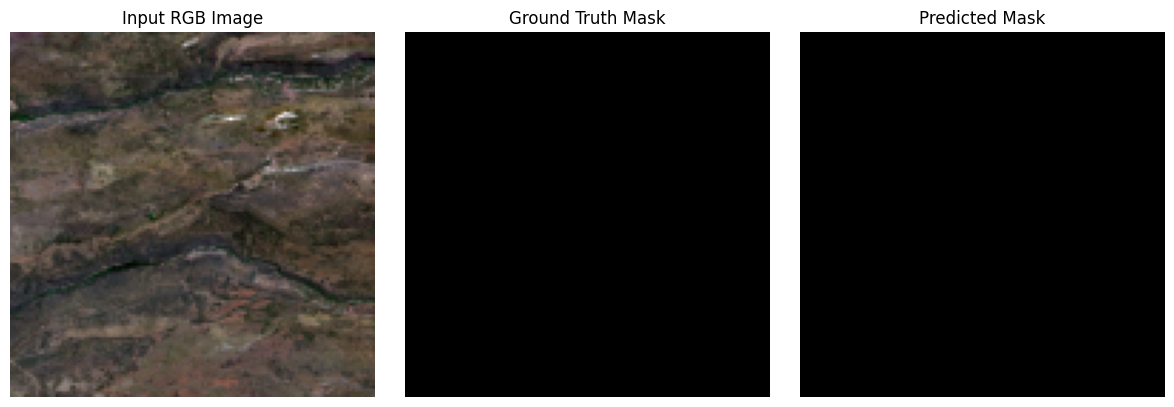

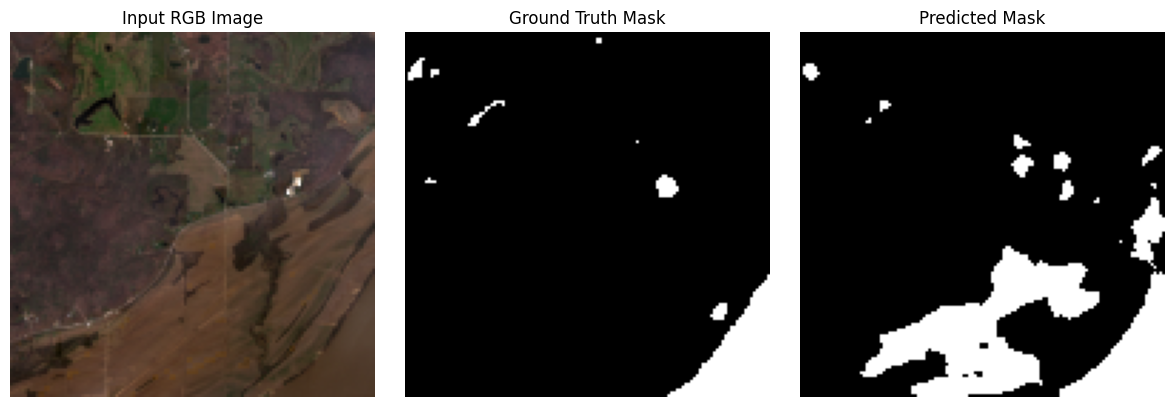

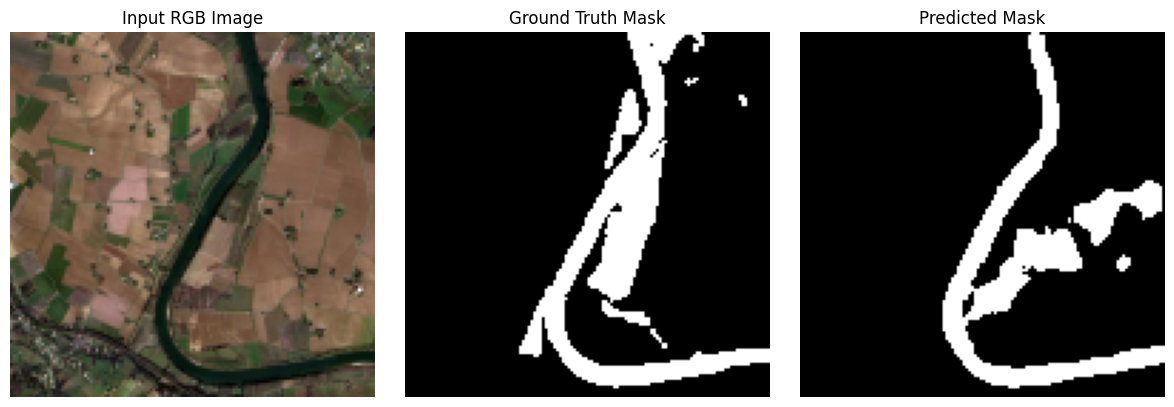

In [50]:
import matplotlib.pyplot as plt

# Get a batch from the validation generator
images, true_masks = next(iter(val_generator))

# Predict masks
pred_masks = model2.predict(images)
pred_masks = (pred_masks > 0.5).astype(np.uint8)  # Binarize prediction

# Show a few comparisons
num_samples = 3  # Number of samples to show
for i in range(num_samples):
    plt.figure(figsize=(12, 4))

    # RGB image (use channels 1, 2, 3 if available)
    rgb = images[i+5][:, :, [2, 1, 0]]  # assuming channels are in order after drop

    plt.subplot(1, 3, 1)
    plt.imshow(rgb)
    plt.title("Input RGB Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(true_masks[i+5].squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_masks[i+5].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [59]:
model3 = sm.Unet(
    'seresnext50',
    input_shape=INPUT_SHAPE,
    classes=1,
    activation='sigmoid',
    encoder_weights=None,
    encoder_freeze=False,
    decoder_use_batchnorm=True
)
# Define loss and metrics
loss = sm.losses.DiceLoss() + sm.losses.BinaryFocalLoss()
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]


model3.compile(optimizer=Adam(LR),loss=loss,metrics=metrics)

In [60]:
history3 = model3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks,
    batch_size=BATCH_SIZE
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - f1-score: 0.4860 - iou_score: 0.3283 - loss: 0.6935 - val_f1-score: 0.4492 - val_iou_score: 0.2965 - val_loss: 0.7714 - learning_rate: 1.0000e-04
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - f1-score: 0.6437 - iou_score: 0.4888 - loss: 0.5783 - val_f1-score: 0.6551 - val_iou_score: 0.4972 - val_loss: 0.6194 - learning_rate: 1.0000e-04
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - f1-score: 0.7170 - iou_score: 0.5659 - loss: 0.5242 - val_f1-score: 0.6714 - val_iou_score: 0.5152 - val_loss: 0.5646 - learning_rate: 1.0000e-04
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - f1-score: 0.7830 - iou_score: 0.6481 - loss: 0.4338 - val_f1-score: 0.6442 - val_iou_score: 0.4871 - val_loss: 0.5650 - learning_rate: 1.0000e-04
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - f1-score: 0.7451 - iou_score: 0.6184 - loss: 0.4650 - val_f1-score: 0.6671 - val_iou_score: 0.5109 - val_loss: 0.5654 - learning_rate: 1.0000e-04
E

In [61]:
loss,FScore,IOUScore= model3.evaluate(val_generator, steps=5)

print(f'Validation Loss: {loss:.4f}')
print(f'Validation F1-Score: {FScore:.4f}')
print(f'Validation IoU: {IOUScore:.4f}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - f1-score: 0.8154 - iou_score: 0.6902 - loss: 0.3254
Validation Loss: 0.2948
Validation F1-Score: 0.6961
Validation IoU: 0.8192


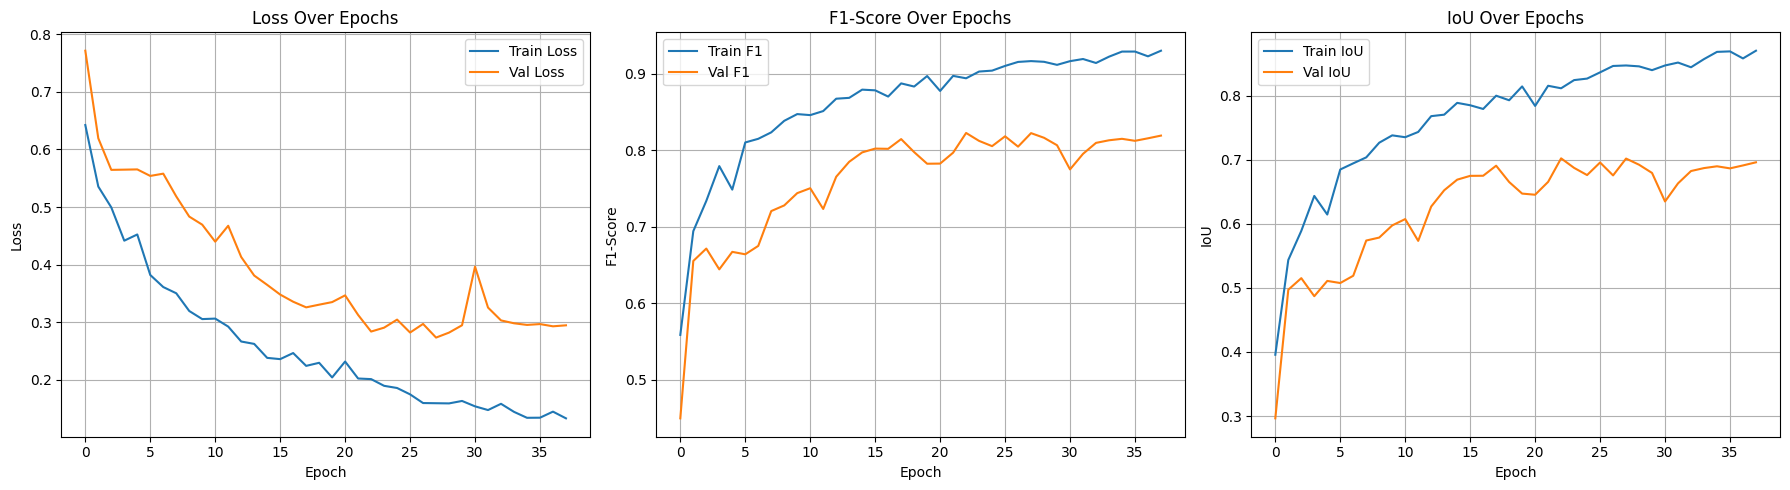

In [65]:
plt.figure(figsize=(18, 5))  # Wider figure for 3 plots

# ----- Loss -----
plt.subplot(1, 3, 1)
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# ----- FScore -----
plt.subplot(1, 3, 2)
plt.plot(history3.history['f1-score'], label='Train F1')
plt.plot(history3.history['val_f1-score'], label='Val F1')
plt.title('F1-Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True)

# ----- IoU -----
plt.subplot(1, 3, 3)
plt.plot(history3.history['iou_score'], label='Train IoU')
plt.plot(history3.history['val_iou_score'], label='Val IoU')
plt.title('IoU Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step


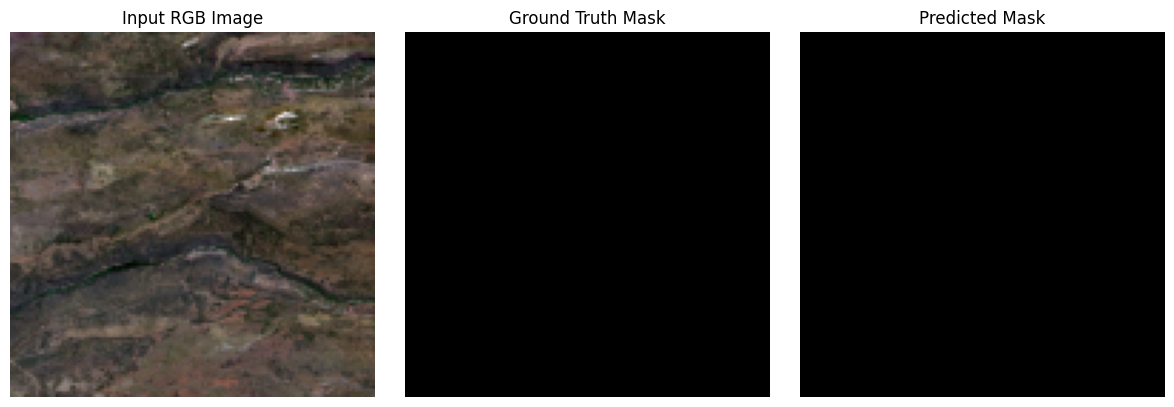

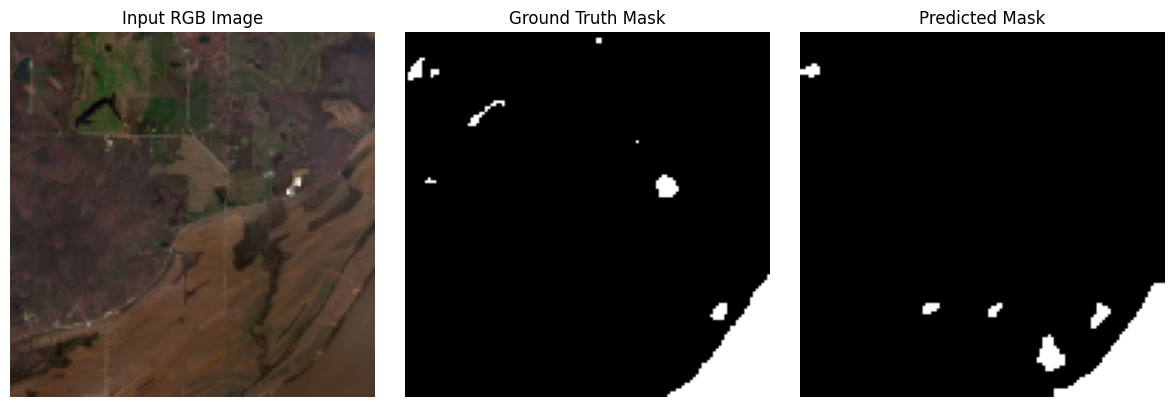

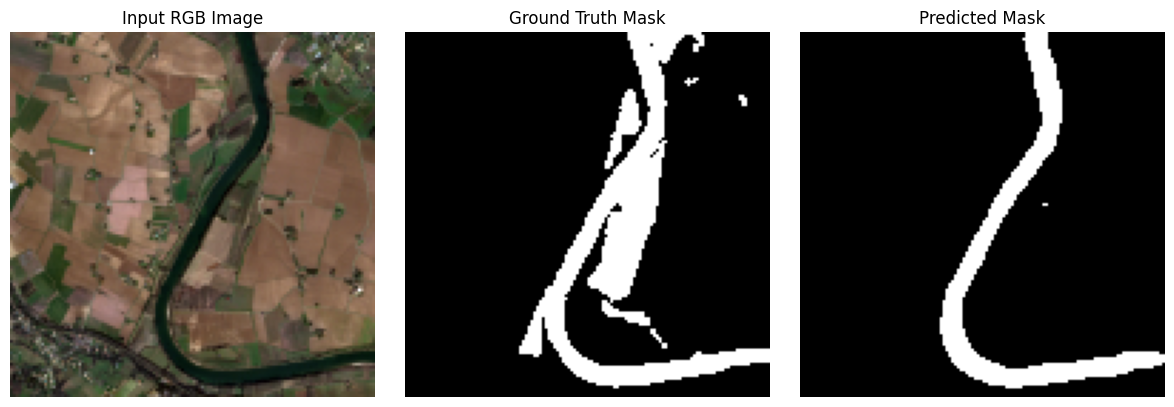

In [62]:
import matplotlib.pyplot as plt

# Get a batch from the validation generator
images, true_masks = next(iter(val_generator))

# Predict masks
pred_masks = model3.predict(images)
pred_masks = (pred_masks > 0.5).astype(np.uint8)  # Binarize prediction

# Show a few comparisons
num_samples = 3  # Number of samples to show
for i in range(num_samples):
    plt.figure(figsize=(12, 4))

    # RGB image (use channels 1, 2, 3 if available)
    rgb = images[i+5][:, :, [2, 1, 0]]  # assuming channels are in order after drop

    plt.subplot(1, 3, 1)
    plt.imshow(rgb)
    plt.title("Input RGB Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(true_masks[i+5].squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_masks[i+5].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [68]:
import albumentations as A
from albumentations.core.composition import OneOf

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=20, p=0.5),
    A.GaussianBlur(p=0.2),
    A.RandomBrightnessContrast(p=0.3),
])

model3 = sm.Unet(
    'seresnext50',
    input_shape=INPUT_SHAPE,
    classes=1,
    activation='sigmoid',
    encoder_weights=None,
    encoder_freeze=False,
    decoder_use_batchnorm=True,
    decoder_dropout=0.3
)

from segmentation_models.losses import DiceLoss, BinaryFocalLoss

dice_loss = DiceLoss()
focal_loss = BinaryFocalLoss()
loss = 0.5 * dice_loss + 0.5 * focal_loss

optimizer = Adam(learning_rate=1e-4)
model3.compile(optimizer=Adam(1e-4), loss=loss, metrics=metrics)


In [ ]:
history3 = model3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks,
    batch_size=BATCH_SIZE
)

Epoch 1/50
